In [1]:
from os import listdir
from os.path import isfile, join
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
def process_json(json, cate = None):
    """
    return {
      "mempool": num | None,
      "consensus": str,
      "delay": num | None,
      "batch_size": num,
      "transaction_size": num,
      "leader_rotation": num | None,
      "nodes": num | None,
      "rate": num,
      "latency": num,
      "consensus-latency": num | None,
      "throughput": num,
    }
    """
    if json["input"]["consensus"] == "Narwhal":
        row = {
        "consensus": "Narwhal",
        "batch_size": json["input"]["parameters"]["batch_size"] // json["input"]["parameters"]["transaction_size"],
        "transaction_size": json["input"]["parameters"]["transaction_size"],
        "rate" : json["input"]["client"]["injection_rate"],
        "latency": [json["output"]["latency"]],
        "throughput": [json["output"]["throughput"]],
        }
    else:
        if json["input"]["consensus"] != "HotStuff":
            json["input"]["consensus"] = "Jasmine"
        row = {
            "mempool": json["input"]["node_settings"]["mempool_size"],
            "consensus": json["input"]["consensus"],
            "batch_size":json["input"]["node_settings"]["batch_size"],
            "transaction_size": json["input"]["node_settings"]["transaction_size"],
            "leader_rotation": json["input"]["node_settings"]["leader_rotation"],
            "nodes": len(json["input"]["peer_addrs"]),
            "consensus-latency":[json["output"]["average_delay"]],
            "rate" : json["input"]["client"]["injection_rate"],
            "latency": [json["output"]["e2e_delay"]],
            "throughput": [json["output"]["consensus_throughput"]],
        }
    if "delay" in json["input"]:
        row["delay"] = json["input"]["delay"]
    if cate is None:
        row["cate"] = (lambda x: "{consensus}-{batch_size}-{transaction_size}".format_map(x))(row)
    else:
        row["cate"] = cate(row)
        
    return pd.DataFrame(row)

def process_dir(dir, cate = None, filter_protocol = None, filter_cates = None, ax = None, rename = None, filter_data = None, squash = True, use_ms = True, log = False):
    """
    cate: lambda Dict: str 
    """
    fs = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    fs = [join(mypath, f) for f in fs if f.startswith('result')]
    fs
    df = pd.DataFrame()

    for f in fs:
        with open(f) as file:
            try:
                data = json.load(file)
            except Exception as e:
                print("FILE NOT LOAD", f)
                raise e
        r = process_json(data, cate)

        if use_ms == False:
            r["latency"] = r["latency"] / 1000
        if filter_data is not None:
            try:
                df = pd.concat([df, r]) if filter_data(r) else df
            except KeyError as e:
                print(r, e)
                raise e
        else:
            df = pd.concat([df, r])

    if len(df) == 0:
        raise Exception('Empty data!')
    
    # Rename columns
    if rename is not None:
        df = df.replace(rename)
        
    df = df.sort_values(by=["batch_size", "transaction_size", "nodes", "leader_rotation", "consensus", "cate", "rate"])

    if squash:
        df = df.groupby(["cate", "rate"],sort=False,).agg({"throughput": ["count","mean"], "latency": ["mean"]})
        df = df.droplevel(axis=1, level=0).reset_index().set_axis(['cate', 'rate', 'count', 'throughput', 'latency'], axis=1, copy=True)
    

    if filter_cates is not None:
        df = df[df.cate.isin(filter_cates)]
    
    if filter_protocol is not None:
        df = df[df.cate.str.startswith(filter_protocol)]

    hue_order = list(dict.fromkeys(list(df.cate)))

    df.index.name = "index"
    
    return sns.lineplot(
        data=df,
        x="throughput", y="latency",sort=False,
        hue="cate", markers=True, dashes=False, style="cate",
        hue_order=list(dict.fromkeys(list(df.cate))),
        ax = ax
    ), df
def save_data(data, base_name, path = "."):
    res = []
    [res.append(x) for x in data.cate if x not in res]
    file_name = lambda x: f"{base_name}-{x.lower()}.csv"
    for cate in res:
        file = join(path, file_name(cate))
        print("save to", file)
        data[data.cate == cate].to_csv(file)

Text(0.5, 1.0, 'Different Batch Sizes')

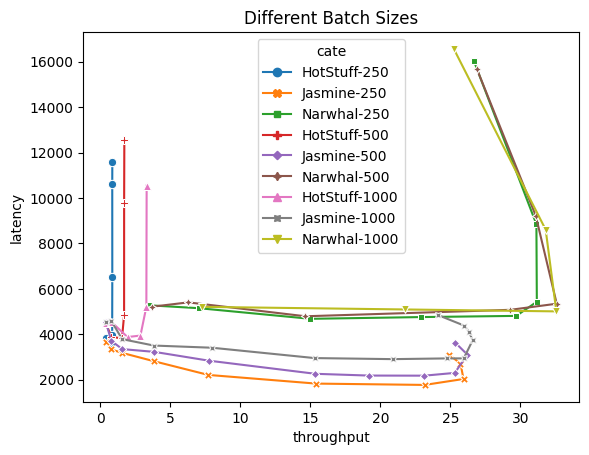

In [135]:
mypath = "./1-plans"
cate = lambda x: "{consensus}-{batch_size}".format_map(x)
pic, data = process_dir(mypath, cate=cate, filter_protocol="")
plt.title('Different Batch Sizes')

In [134]:
data

,cate,rate,count,throughput,latency
index,,,,,
16,Narwhal-250,1000,2,3.5615,5273.0
17,Narwhal-250,2000,2,7.0460,5147.5
18,Narwhal-250,4000,2,15.0055,4680.5
19,Narwhal-250,6000,2,22.8770,4757.0
20,Narwhal-250,8000,2,29.7075,4809.5
21,Narwhal-250,9000,2,31.1775,5430.5
22,Narwhal-250,10000,2,31.1465,8844.5
23,Narwhal-250,12000,2,26.6720,16048.5
41,Narwhal-500,1000,2,3.6480,5211.0


<AxesSubplot:title={'center':'Different Transaction Sizes'}, xlabel='throughput', ylabel='latency'>

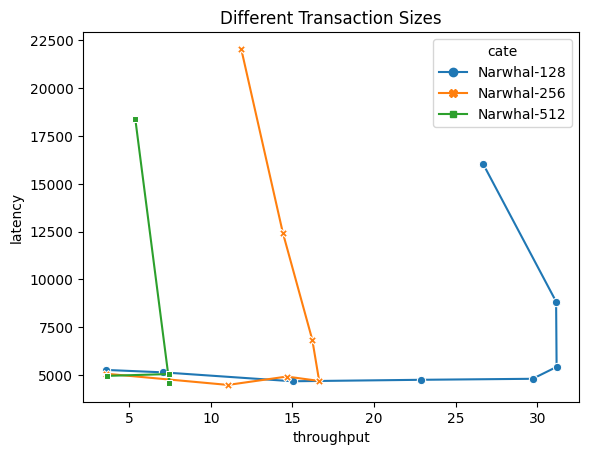

In [159]:
mypath = "./2-plans"
cate = lambda x: "{consensus}-{transaction_size}".format_map(x)
pic, data = process_dir(mypath, cate = cate, filter_protocol="Narwhal")
plt.title('Different Transaction Sizes')
pic

In [160]:
data

,cate,rate,count,throughput,latency
index,,,,,
19,Narwhal-128,1000,2,3.56150,5273.000
20,Narwhal-128,2000,2,7.04600,5147.500
21,Narwhal-128,4000,2,15.00550,4680.500
22,Narwhal-128,6000,2,22.87700,4757.000
23,Narwhal-128,8000,2,29.70750,4809.500
24,Narwhal-128,9000,2,31.17750,5430.500
25,Narwhal-128,10000,2,31.14650,8844.500
26,Narwhal-128,12000,2,26.67200,16048.500
41,Narwhal-256,1000,2,3.60400,5072.500


<AxesSubplot:title={'center':'Different Scales with Maximum faults'}, xlabel='throughput', ylabel='latency'>

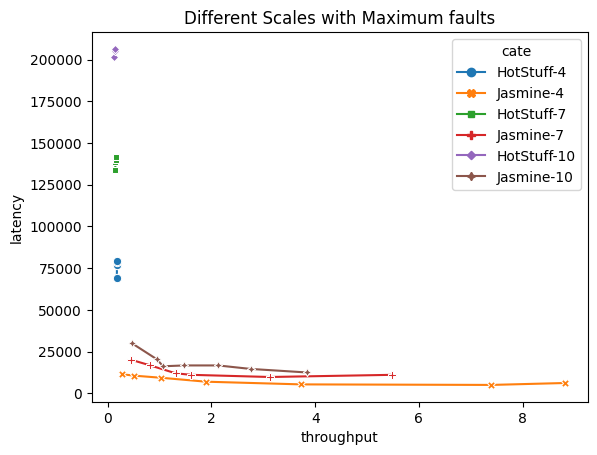

In [31]:
mypath = "./4-plans"
cate = lambda x: "{consensus}-{nodes}".format_map(x)
pic, data = process_dir(mypath, cate = cate, filter_protocol="")
plt.title('Different Scales with Maximum faults')
pic
# 7-2

In [32]:
data[data["count"]==1]

,cate,rate,count,throughput,latency
index,,,,,


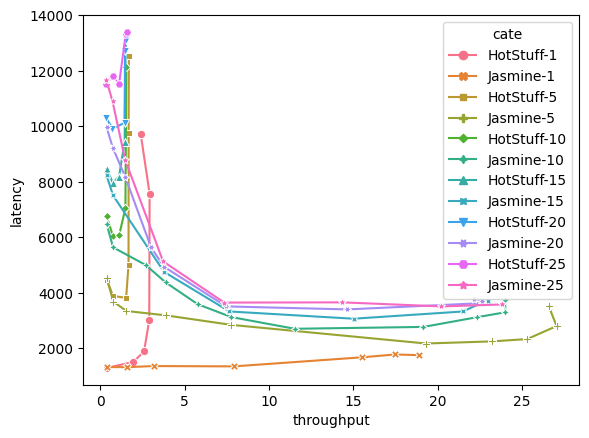

In [67]:
mypath = "./5-plans"
cate = lambda x: "{consensus}-{leader_rotation}".format_map(x)
pic, data = process_dir(mypath, cate = cate)

In [68]:
data[data["count"]==1]

,cate,rate,count,throughput,latency
index,,,,,
9,Jasmine-1,2000,1,7.924344,1346.670549


<AxesSubplot:xlabel='throughput', ylabel='latency'>

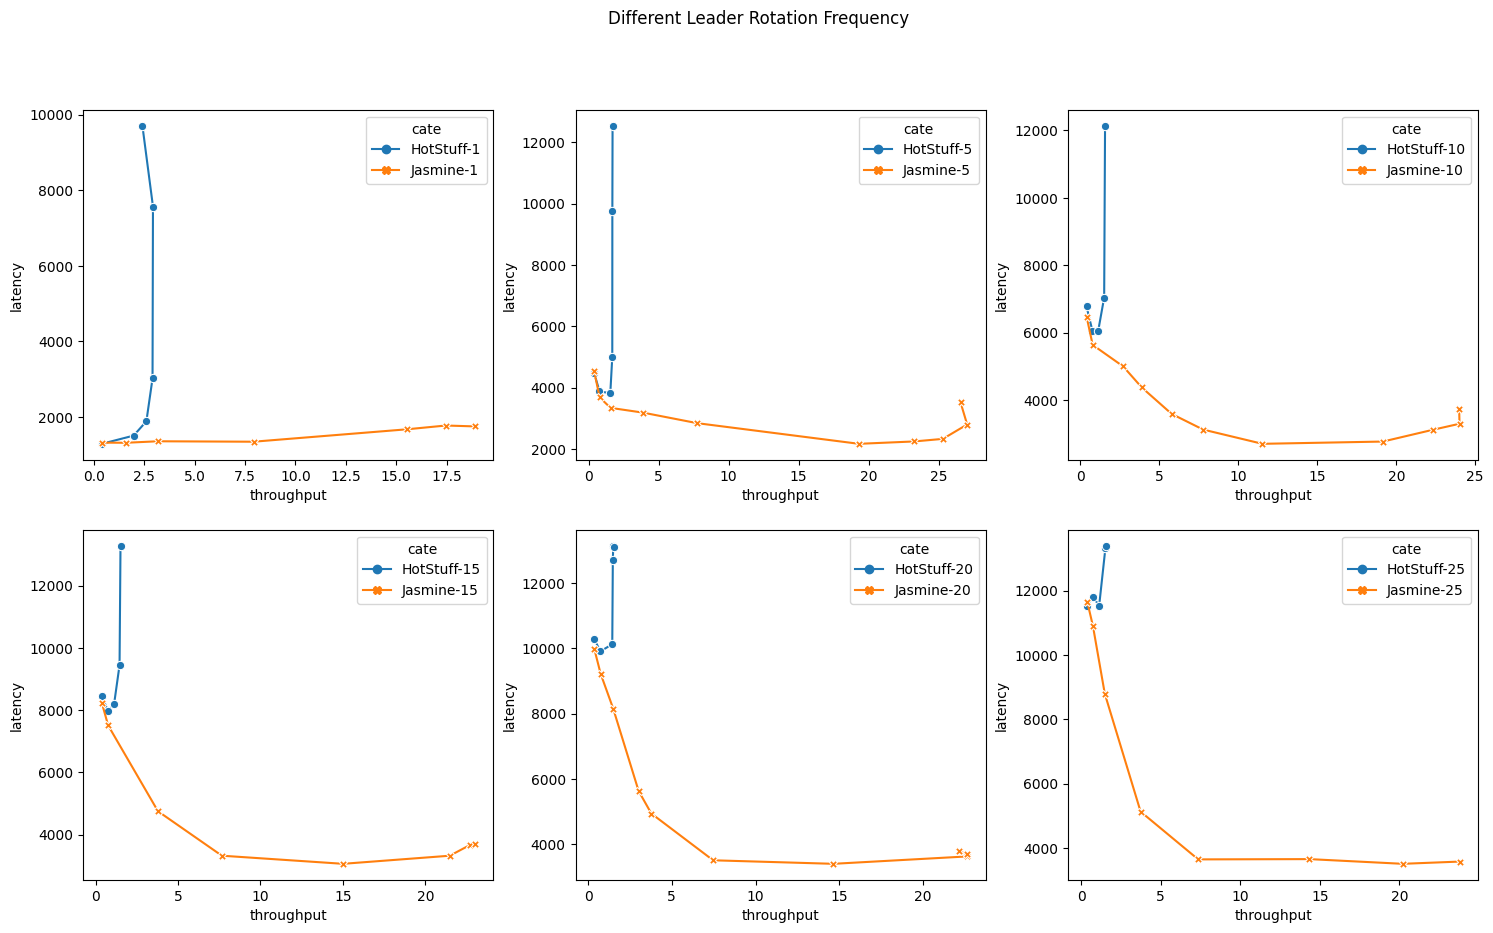

In [74]:
mypath = "./5-plans"
# cate = lambda x: "{consensus}-{leader_rotation}".format_map(x)
# pic, data1 = process_dir(mypath, cate = cate)mypath = "./5-plans"
cate = lambda x: "{consensus}-{leader_rotation}".format_map(x)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
pic, data1 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 1).any(), ax = axes[0,0])
pic, data2 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 5).any(), ax = axes[0,1])
pic, data3 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 10).any(), ax = axes[0,2])
pic, data4 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 15).any(), ax = axes[1,0])
pic, data5 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 20).any(), ax = axes[1,1])
pic, data6 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 25).any(), ax = axes[1,2])
# pic, _ = process_dir(mypath, cate = cate, filter_data = lambda x: (x["leader_rotation"] == 1000000).any(), ax = axes[1,2], rename = rename)
plt.suptitle('Different Leader Rotation Frequency')
pic

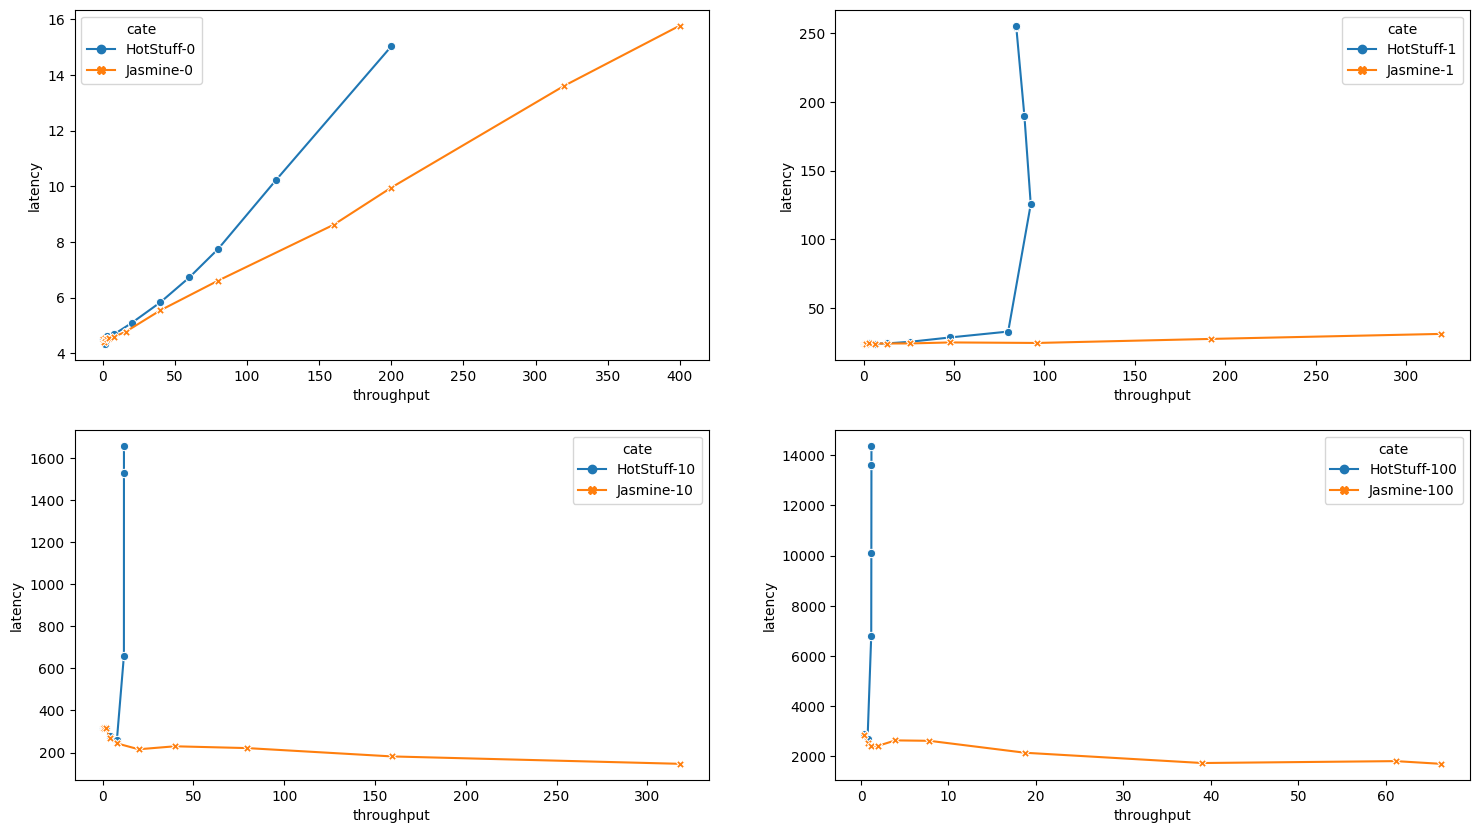

In [103]:
mypath = "./3-plans"
cate = lambda x: "{consensus}-{delay}".format_map(x)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
pic, data1 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["delay"] == 0).any(), ax = axes[0,0])
pic, data2 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["delay"] == 1).any(), ax = axes[0,1])
pic, data3 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["delay"] == 10).any(), ax = axes[1,0])
pic, data4 = process_dir(mypath, cate = cate, filter_data = lambda x: (x["delay"] == 100).any(), ax = axes[1,1])


In [101]:
data3

,cate,rate,count,throughput,latency
index,,,,,
0,HotStuff-10,100,2,0.394559,318.562951
1,HotStuff-10,200,2,0.787577,318.474026
2,HotStuff-10,500,2,1.971131,317.169634
3,HotStuff-10,1000,2,3.938690,277.232311
4,HotStuff-10,2000,2,7.859633,260.968126
5,HotStuff-10,5000,2,11.739847,1527.198108
6,HotStuff-10,10000,2,11.740352,1658.695506
7,Jasmine-10,100,2,0.393825,317.271547
8,Jasmine-10,200,2,0.788599,316.006390


save to output/batch_size-hotstuff-250.csv
save to output/batch_size-jasmine-250.csv
save to output/batch_size-narwhal-250.csv
save to output/batch_size-hotstuff-500.csv
save to output/batch_size-jasmine-500.csv
save to output/batch_size-narwhal-500.csv
save to output/batch_size-hotstuff-1000.csv
save to output/batch_size-jasmine-1000.csv
save to output/batch_size-narwhal-1000.csv
save to output/transaction_size-hotstuff-128.csv
save to output/transaction_size-jasmine-128.csv
save to output/transaction_size-narwhal-128.csv
save to output/transaction_size-hotstuff-256.csv
save to output/transaction_size-jasmine-256.csv
save to output/transaction_size-narwhal-256.csv
save to output/transaction_size-hotstuff-512.csv
save to output/transaction_size-jasmine-512.csv
save to output/transaction_size-narwhal-512.csv
save to output/delay-hotstuff-0.csv
save to output/delay-hotstuff-1.csv
save to output/delay-hotstuff-10.csv
save to output/delay-hotstuff-100.csv
save to output/delay-jasmine-0.csv

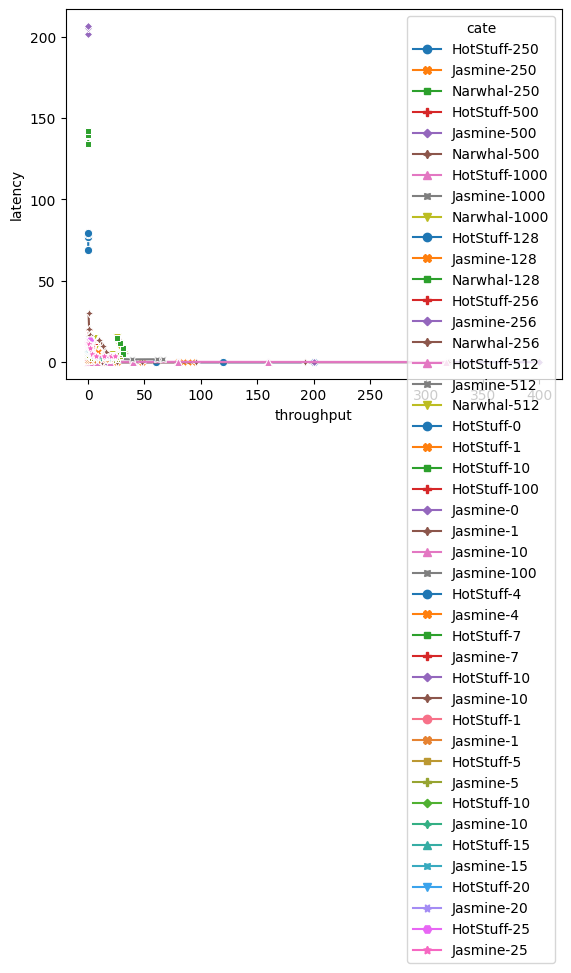

In [104]:
mypath = "./1-plans"
cate = lambda x: "{consensus}-{batch_size}".format_map(x)
_, data = process_dir(mypath, cate=cate, use_ms = False)
save_data(data, "batch_size", path="output")

mypath = "./2-plans"
cate = lambda x: "{consensus}-{transaction_size}".format_map(x)
_, data = process_dir(mypath, cate=cate, use_ms = False)
save_data(data, "transaction_size", path="output")

mypath = './3-plans'
cate = lambda x: "{consensus}-{delay}".format_map(x)
_, data = process_dir(mypath, cate = cate, use_ms = False)
save_data(data, "delay", path="output")

mypath = "./4-plans"
cate = lambda x: "{consensus}-{nodes}".format_map(x)
_, data = process_dir(mypath, cate = cate, use_ms = False)
save_data(data, "failts", path="output")

mypath = "./5-plans"
cate = lambda x: "{consensus}-{leader_rotation}".format_map(x)
pic, data = process_dir(mypath, cate = cate, use_ms = False)
save_data(data, "switch", path="output")